# Team Details:

### Group Number - 31

- Sathuluri, Durga Abhist (dsathul1@binghamton.edu)
- Kudlur, Sneha (skudlur1@binghamton.edu)
- Bangaru, Ravi (rbangar1@binghamton.edu)
- Ardhageri, Sai Krishna Reddy (sardhag1@binghamton.edu)
- Pinnika, Naveen Chandra (npinnik1@binghamton.edu)
- Patirla, Jai Aditya (jaditya1@binghamton.edu)








Problem 1:




Image synthesis of high quality using diffusion probabilistic models. CIFAR10 FID=3.17 without conditions, LSUN samples comparable to GANs. This paper demonstrates connections between denoising score matching and Langevin dynamics while also providing log likelihoods and rate-distortion curves.Authors showed how to compress data with controllable lossiness while still allowing for reconstructions and interpolations at multiple granularities.

Problem - 2:

```
Implement DDPM and test it on 2-dimensional Swiss roll data. You should output Fig.3 of the blog intro 2.
```



In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init
from torch.autograd import Variable
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import keras
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
import random
import tensorflow as tf
from matplotlib import pyplot as plt



In [ ]:
# from helper_plot import hdr_plot_style
def hdr_plot_style():
    plt.style.use('dark_background')
    mpl.rcParams.update({'font.size': 18, 'lines.linewidth': 3, 'lines.markersize': 15})
    mpl.rcParams['ps.useafm'] = True
    mpl.rcParams['pdf.use14corefonts'] = True
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams['font.family'] = 'sans-serif'
    mpl.rcParams['font.sans-serif'] = 'Courier New'
    colors = mpl.cycler('color', ['#3388BB', '#EE6666', '#9988DD', '#EECC55', '#88BB44', '#FFBBBB'])
    plt.rc('legend', facecolor='#666666EE', edgecolor='white', fontsize=16)
    plt.rc('grid', color='white', linestyle='solid')
    plt.rc('text', color='white')
    plt.rc('xtick', direction='out', color='white')
    plt.rc('ytick', direction='out', color='white')
    plt.rc('patch', edgecolor='#E6E6E6')

In [ ]:
def sample_batch(size, noise=1.0):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0

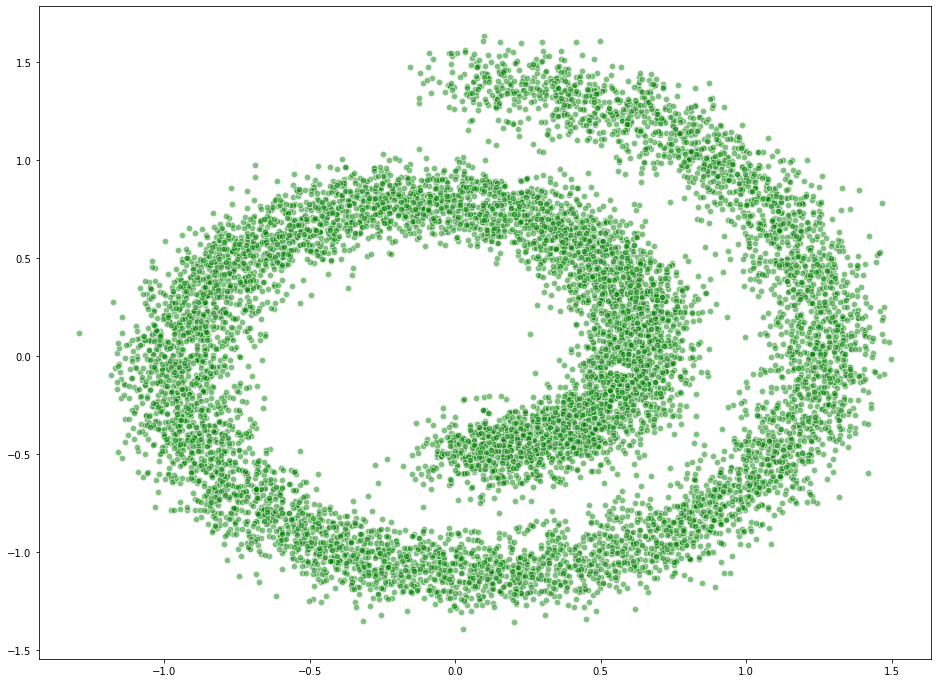

In [ ]:
data = sample_batch(10**4).T
plt.figure(figsize=(16, 12))
plt.scatter(*data, alpha=0.5, color='green', edgecolor='white', s=40)

Problem 3: Implement DDPM and test it on 2-dimensional Swiss roll data. You should output Fig.3 of the blog intro 2.

In [ ]:
def sliced_score_matching(model, samples):
    samples.requires_grad_(True)
    vectors = torch.randn_like(samples)
    vectors = vectors / torch.norm(vectors, dim=-1, keepdim=True)
    logp, jvp = autograd.functional.jvp(model, samples, vectors, create_graph=True)
    norm_loss = (logp * vectors) ** 2 / 2.
    v_jvp = jvp * vectors
    jacob_loss = v_jvp
    loss = jacob_loss + norm_loss
    return loss.mean(-1).mean(-1)

In [ ]:
def denoising_score_matching(scorenet, samples, sigma=0.01):
    perturbed_samples = samples + torch.randn_like(samples) * sigma
    target = - 1 / (sigma ** 2) * (perturbed_samples - samples)
    scores = scorenet(perturbed_samples)
    target = target.view(target.shape[0], -1)
    scores = scores.view(scores.shape[0], -1)
    loss = 1 / 2. * ((scores - target) ** 2).sum(dim=-1).mean(dim=0)
    return loss

In [ ]:
model = nn.Sequential(
    nn.Linear(2, 128), nn.Softplus(),
    nn.Linear(128, 128), nn.Softplus(),
    nn.Linear(128, 2)
)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()
for t in range(5000):
    loss = denoising_score_matching(model, dataset)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if ((t % 1000) == 0):
        print(loss)

tensor(9947.5596, grad_fn=<MulBackward0>)
tensor(9922.1660, grad_fn=<MulBackward0>)
tensor(9892.1768, grad_fn=<MulBackward0>)
tensor(9881.6504, grad_fn=<MulBackward0>)
tensor(10000.0205, grad_fn=<MulBackward0>)


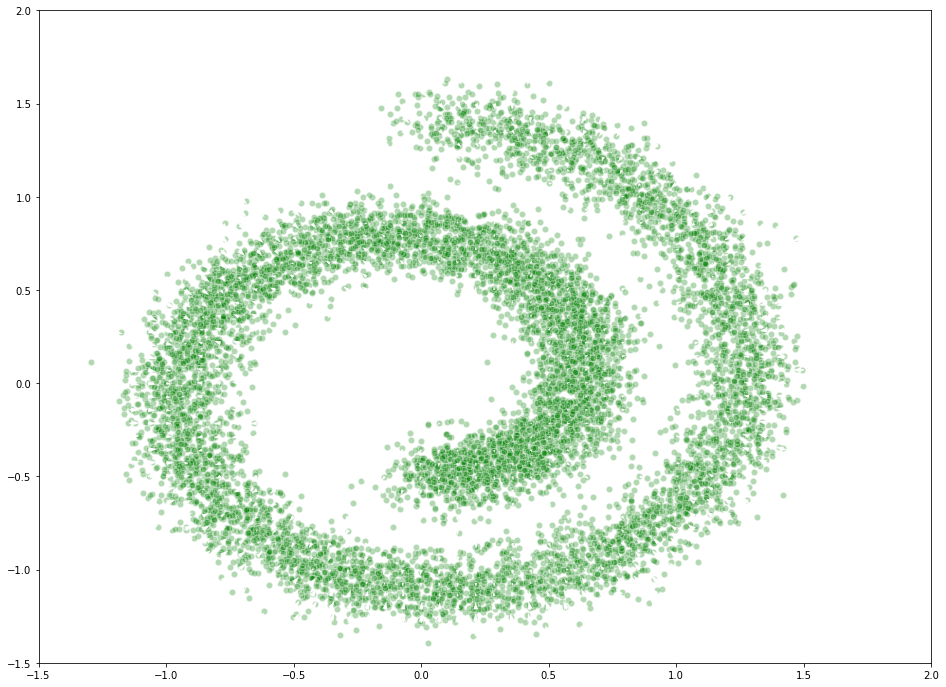

In [ ]:
def plot_gradients(model, data, plot_scatter=True):
    xx = np.stack(np.meshgrid(np.linspace(-1.5, 2.0, 50), np.linspace(-1.5, 2.0, 50)), axis=-1).reshape(-1, 2)
    scores = model(torch.from_numpy(xx).float()).detach()
    scores_norm = np.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
    scores_log1p = scores / (scores_norm + 1e-9) * np.log1p(scores_norm)
    plt.figure(figsize=(16,12))
    if (plot_scatter):
        plt.scatter(*data, alpha=0.3, color='green', edgecolor='white', s=40)
    plt.quiver(xx.T[0], xx.T[1], scores_log1p[:,0], scores_log1p[:,1], width=0.002, color='white')
    plt.xlim(-1.5, 2.0)
    plt.ylim(-1.5, 2.0)
plot_gradients(model, data)

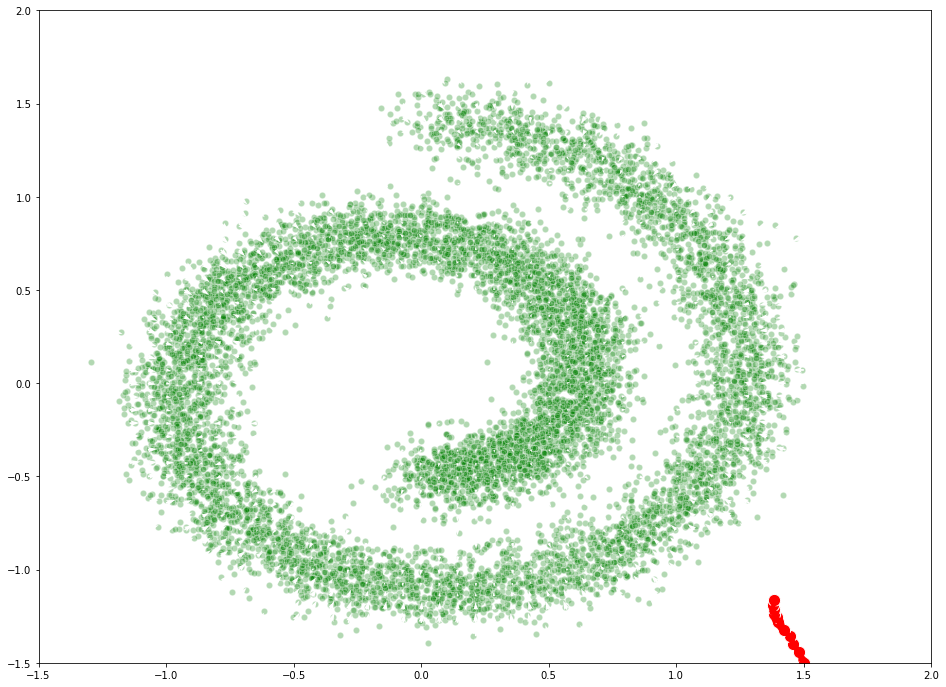

In [ ]:
def sample_langevin(model, x, n_steps=10, eps=1e-3, decay=.9, temperature=1.0):
    x_sequence = [x.unsqueeze(0)]
    for s in range(n_steps):
        z_t = torch.rand(x.size())
        x = x + (eps / 2) * model(x) + (np.sqrt(eps) * temperature * z_t)
        x_sequence.append(x.unsqueeze(0))
        eps *= decay
    return torch.cat(x_sequence)

x = torch.Tensor([1.5, -1.5])
samples = sample_langevin(model, x).detach()
plot_gradients(model, data)
plt.scatter(samples[:, 0], samples[:, 1], color='red', edgecolor='white', s=150)
# draw arrows for each mcmc step
deltas = (samples[1:] - samples[:-1])
deltas = deltas - deltas / torch.tensor(np.linalg.norm(deltas, keepdims=True, axis=-1)) * 0.04
for i, arrow in enumerate(deltas):
    plt.arrow(samples[i,0], samples[i,1], arrow[0], arrow[1], width=1e-4, head_width=2e-2, color="red", linewidth=3)

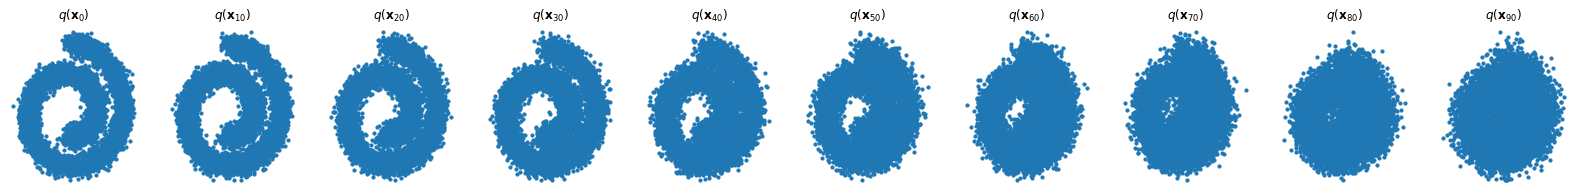

In [ ]:
def forward_process(x_start, n_steps, noise=None):
    """ Diffuse the data (t == 0 means diffused for 1 step) """
    x_seq = [x_start]
    for n in range(n_steps):
        x_seq.append((torch.sqrt(1 - betas[n]) * x_seq[-1]) + (betas[n] * torch.rand_like(x_start)))
    return x_seq
n_steps = 100
betas = torch.tensor([0.035] * n_steps)
dataset = torch.Tensor(data.T).float()
x_seq = forward_process(dataset, n_steps, betas)
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    axs[i].scatter(x_seq[int((i / 10.0) * n_steps)][:, 0], x_seq[int((i / 10.0) * n_steps)][:, 1], s=10);
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(int((i / 10.0) * n_steps))+'})$')

In [ ]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

betas = make_beta_schedule(schedule='sigmoid', n_timesteps=n_steps, start=1e-5, end=1e-2)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [ ]:
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

In [ ]:
def q_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

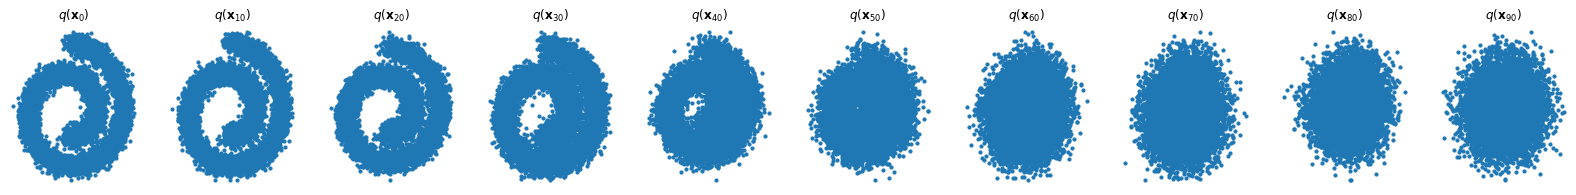

In [ ]:
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    q_i = q_sample(dataset, torch.tensor([i * 10]))
    axs[i].scatter(q_i[:, 0], q_i[:, 1], s=10);
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

In [ ]:
class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out

In [ ]:
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128, 2)

    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        x = F.softplus(self.lin3(x, y))
        return self.lin4(x)

In [ ]:
def p_mean_variance(model, x, t):
    # Go through model
    out = model(x, t)
    # Extract the mean and variance
    mean, log_var = torch.split(out, 2, dim=-1)
    var = torch.exp(log_var)
    return mean, log_var

In [ ]:
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var


In [ ]:
def loss_likelihood_bound(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # Perform diffusion for step t
    x_t = q_sample(x_0, t)
    # Compute the true mean and variance
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t)
    # Infer the mean and variance with our model
    model_mean, model_var = p_mean_variance(model, x_t, t)
    # Compute the loss
    return compute_loss(true_mean, true_var, model_mean, model_var)

In [ ]:
def normal_kl(mean1, logvar1, mean2, logvar2):
    kl = 0.5 * (-1.0 + logvar2 - logvar1 + torch.exp(logvar1 - logvar2) + ((mean1 - mean2) ** 2) * torch.exp(-logvar2))
    return kl

def entropy(val):
    return (0.5 * (1 + np.log(2. * np.pi))) + 0.5 * np.log(val)

In [ ]:
def compute_loss(true_mean, true_var, model_mean, model_var):
    # the KL divergence between model transition and posterior from data
    KL = normal_kl(true_mean, true_var, model_mean, model_var).float()
    # conditional entropies H_q(x^T|x^0) and H_q(x^1|x^0)
    H_start = entropy(betas[0].float()).float()
    beta_full_trajectory = 1. - torch.exp(torch.sum(torch.log(alphas))).float()
    H_end = entropy(beta_full_trajectory.float()).float()
    H_prior = entropy(torch.tensor([1.])).float()
    negL_bound = KL * n_steps + H_start - H_end + H_prior
    # the negL_bound if this was an isotropic Gaussian model of the data
    negL_gauss = entropy(torch.tensor([1.])).float()
    negL_diff = negL_bound - negL_gauss
    L_diff_bits = negL_diff / np.log(2.)
    L_diff_bits_avg = L_diff_bits.mean()
    return L_diff_bits_avg

In [ ]:
def p_sample(model, x, t):
    t = torch.tensor([t])
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    # Model output
    eps_theta = model(x, t)
    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return (sample)

In [ ]:
def p_sample_loop(model, shape):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x)
    return x_seq

In [ ]:
def approx_standard_normal_cdf(x):
    return 0.5 * (1.0 + torch.tanh(torch.tensor(np.sqrt(2.0 / np.pi)) * (x + 0.044715 * torch.pow(x, 3))))

def discretized_gaussian_log_likelihood(x, means, log_scales):
    # Assumes data is integers [0, 255] rescaled to [-1, 1]
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(torch.clamp(cdf_plus, min=1e-12))
    log_one_minus_cdf_min = torch.log(torch.clamp(1 - cdf_min, min=1e-12))
    cdf_delta = cdf_plus - cdf_min
    log_probs = torch.where(x < -0.999, log_cdf_plus, torch.where(x > 0.999, log_one_minus_cdf_min, torch.log(torch.clamp(cdf_delta, min=1e-12))))
    return log_probs

In [ ]:
def loss_variational(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # Perform diffusion for step t
    x_t = q_sample(x_0, t)
    # Compute the true mean and variance
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t)
    # Infer the mean and variance with our model
    model_mean, model_var = p_mean_variance(model, x_t, t)
    # Compute the KL loss
    kl = normal_kl(true_mean, true_var, model_mean, model_var)
    kl = torch.mean(kl.view(batch_size, -1), dim=1) / np.log(2.)
    # NLL of the decoder
    decoder_nll = -discretized_gaussian_log_likelihood(x_0, means=model_mean, log_scales=0.5 * model_var)
    decoder_nll = torch.mean(decoder_nll.view(batch_size, -1), dim=1) / np.log(2.)
    # At the first timestep return the decoder NLL, otherwise return KL(q(x_{t-1}|x_t,x_0) || p(x_{t-1}|x_t))
    output = torch.where(t == 0, decoder_nll, kl)
    return output.mean(-1)

In [ ]:
def noise_estimation_loss(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
    e = torch.randn_like(x_0)
    # model input
    x = x_0 * a + e * am1
    output = model(x, t)
    return (e - output).square().mean()

In [ ]:
class EMA(object):
    def __init__(self, mu=0.999):
        self.mu = mu
        self.shadow = {}

    def register(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name] = param.data.clone()

    def update(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                self.shadow[name].data = (1. - self.mu) * param.data + self.mu * self.shadow[name].data

    def ema(self, module):
        for name, param in module.named_parameters():
            if param.requires_grad:
                param.data.copy_(self.shadow[name].data)

    def ema_copy(self, module):
        module_copy = type(module)(module.config).to(module.config.device)
        module_copy.load_state_dict(module.state_dict())
        self.ema(module_copy)
        return module_copy

    def state_dict(self):
        return self.shadow

    def load_state_dict(self, state_dict):
        self.shadow = state_dict

tensor(0.5281, grad_fn=<MeanBackward0>)
tensor(0.6217, grad_fn=<MeanBackward0>)
tensor(0.6385, grad_fn=<MeanBackward0>)
tensor(0.3218, grad_fn=<MeanBackward0>)
tensor(0.5986, grad_fn=<MeanBackward0>)
tensor(0.7844, grad_fn=<MeanBackward0>)
tensor(0.8680, grad_fn=<MeanBackward0>)
tensor(0.7595, grad_fn=<MeanBackward0>)
tensor(0.5581, grad_fn=<MeanBackward0>)
tensor(0.4643, grad_fn=<MeanBackward0>)


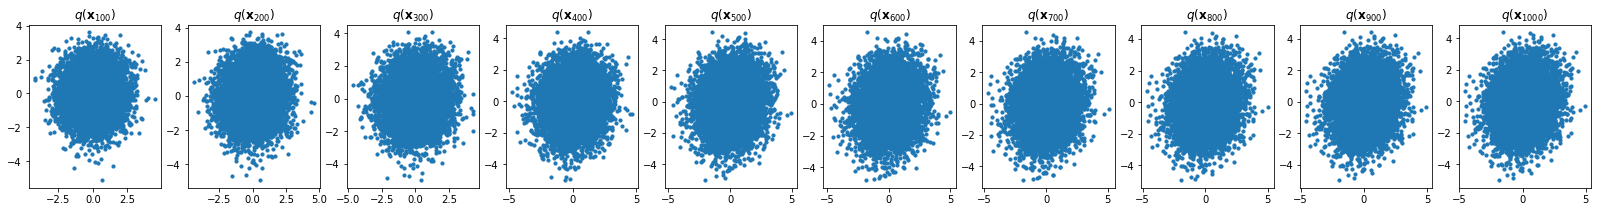

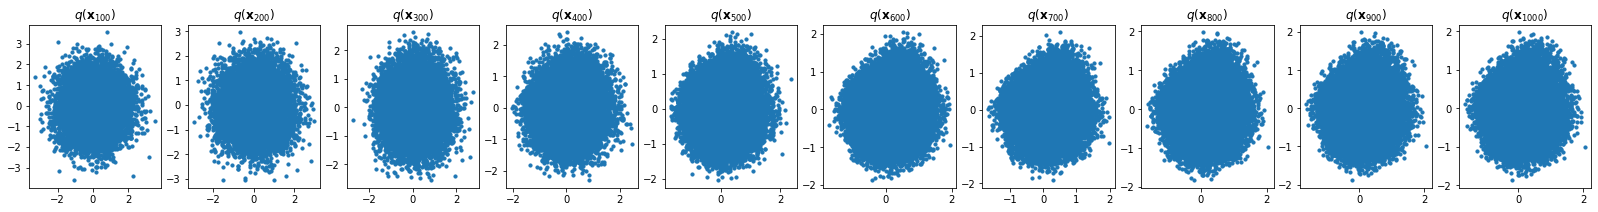

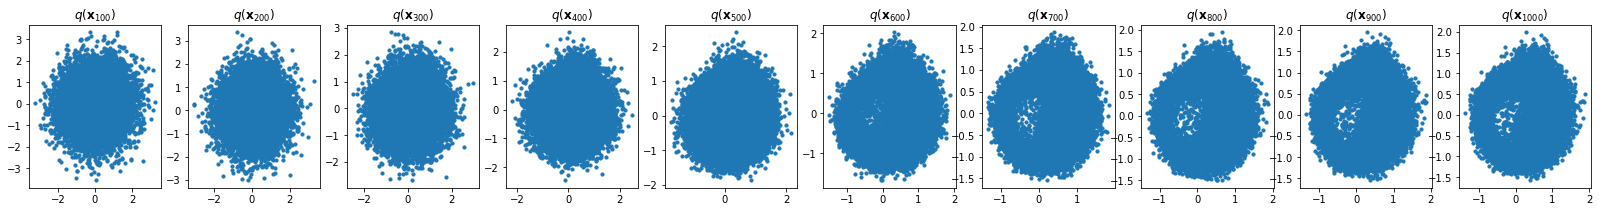

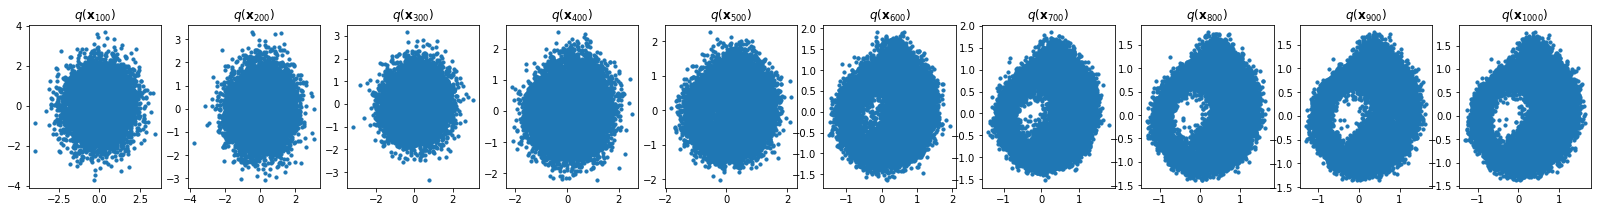

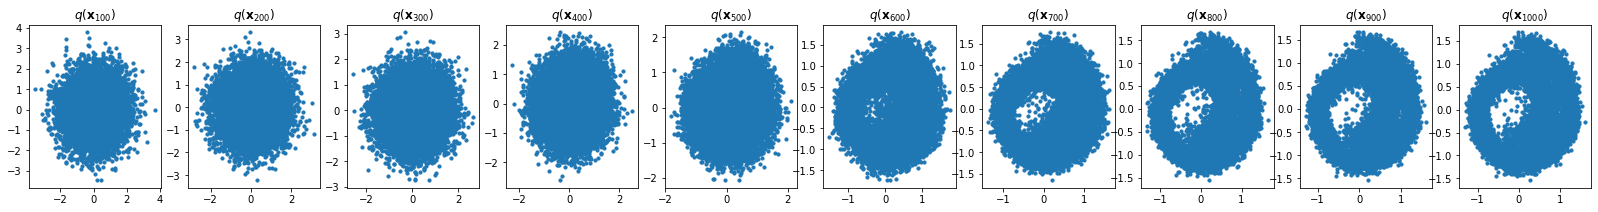

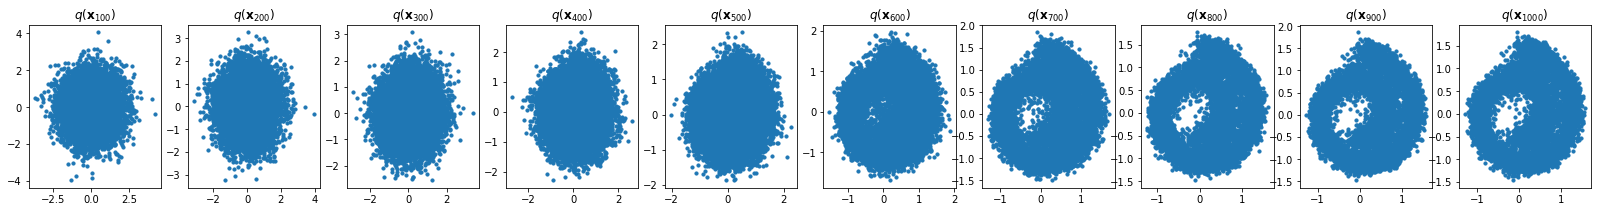

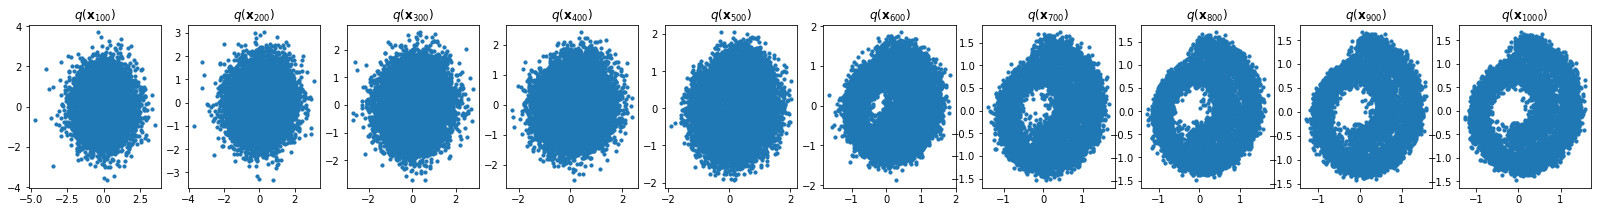

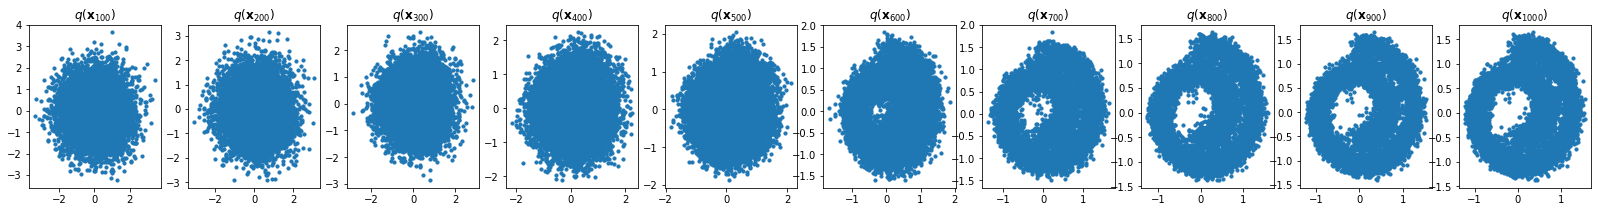

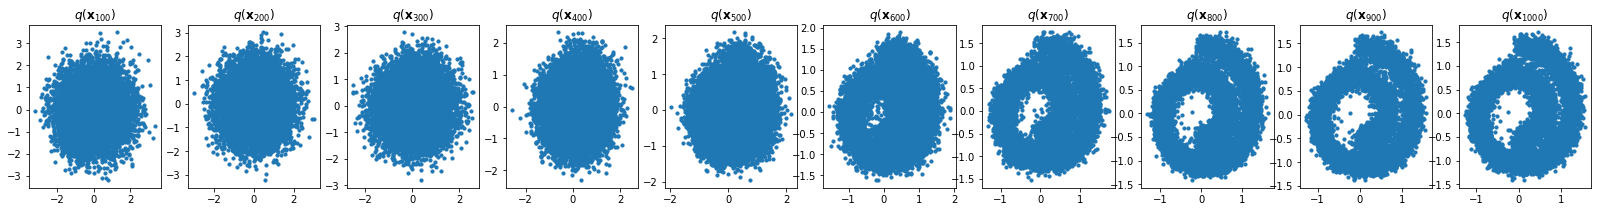

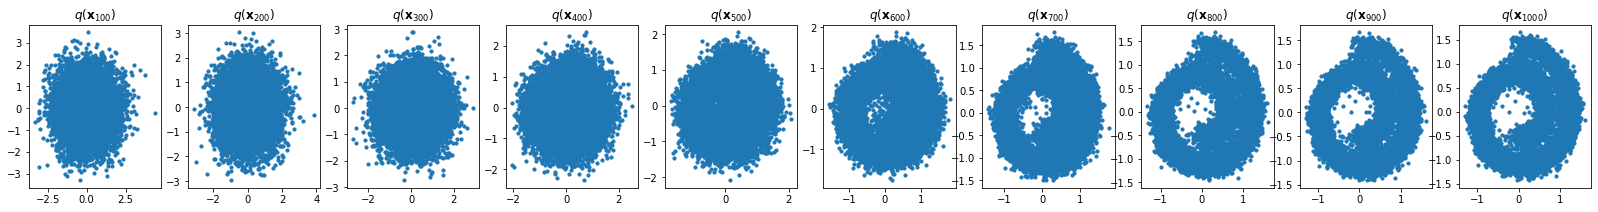

In [ ]:
model = ConditionalModel(n_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()
# Create EMA model
ema = EMA(0.9)
ema.register(model)
# Batch size
batch_size = 128
for t in range(1000):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
        # Update the exponential moving average
        ema.update(model)
    # Print loss
    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10);
            #axs[i-1].set_axis_off();
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

Problem 4: Test DDPM on MNIST dataset. Visualize the denoising process (You should output a figure like Fig. 6 in the paper).

11490434/11490434 [==============================] - 2s 0us/step


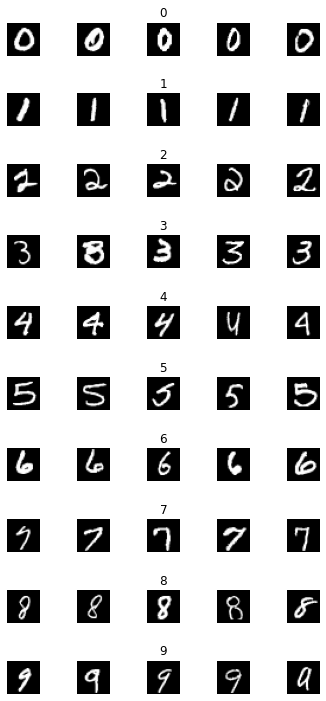

In [ ]:
np.random.seed(0)
(X_train, y_train), (X_test, y_test) = mnist.load_data()
assert(X_train.shape[0] == y_train.shape[0])
assert(X_test.shape[0] == y_test.shape[0])
assert(X_train.shape[1:] == (28, 28))
assert(X_test.shape[1:] == (28, 28))
num_of_samples = []

cols = 5
num_of_classes = 10

fig, axs = plt.subplots(nrows=num_of_classes, ncols=cols,
                       figsize=(5, 10))
fig.tight_layout()
for i in range(cols):
  for j in range(num_of_classes):
    x_selected = X_train[y_train == j]
    axs[j][i].imshow(x_selected[random.randint(0, len(x_selected -1)),
                                :, :],
                    cmap=plt.get_cmap('gray'))
    axs[j][i].axis("off")
    if i==2:
      axs[j][i].set_title(str(j))
      num_of_samples.append(len(x_selected))

In [ ]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
X_train = X_train/255
X_test = X_test/255
num_pixels = 784
X_train = X_train.reshape(X_train.shape[0],
                         num_pixels)
X_test = X_test.reshape(X_test.shape[0],
                         num_pixels)

In [ ]:
def create_model():
  model = Sequential()
  model.add(Dense(10, input_dim = num_pixels,
                  activation = 'relu'))
  model.add(Dense(30, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(num_of_classes, activation='softmax'))
  model.compile(Adam(lr=0.01),
                loss='categorical_crossentropy',
               metrics=['accuracy'])
  return model



In [ ]:
model = create_model()
print(model.summary())

history = model.fit(X_train, y_train, validation_split=0.1,
         epochs=10, batch_size=200, verbose=1, shuffle=1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                7850      
                                                                 
 dense_1 (Dense)             (None, 30)                330       
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
Total params: 8,600
Trainable params: 8,600
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


None
Epoch 1/10
270/270 [==============================] - 4s 4ms/step - loss: 0.6457 - accuracy: 0.7908 - val_loss: 0.3160 - val_accuracy: 0.9070
Epoch 2/10
270/270 [==============================] - 1s 3ms/step - loss: 0.3660 - accuracy: 0.8941 - val_loss: 0.2768 - val_accuracy: 0.9197
Epoch 3/10
270/270 [==============================] - 1s 3ms/step - loss: 0.3352 - accuracy: 0.9023 - val_loss: 0.2822 - val_accuracy: 0.9148
Epoch 4/10
270/270 [==============================] - 1s 3ms/step - loss: 0.3158 - accuracy: 0.9066 - val_loss: 0.2731 - val_accuracy: 0.9237
Epoch 5/10
270/270 [==============================] - 1s 3ms/step - loss: 0.3084 - accuracy: 0.9099 - val_loss: 0.2588 - val_accuracy: 0.9187
Epoch 6/10
270/270 [==============================] - 1s 3ms/step - loss: 0.3004 - accuracy: 0.9108 - val_loss: 0.2428 - val_accuracy: 0.9280
Epoch 7/10
270/270 [==============================] - 1s 3ms/step - loss: 0.2888 - accuracy: 0.9149 - val_loss: 0.2372 - val_accuracy: 0.9297
E

Text(0.5, 0, 'epoch')

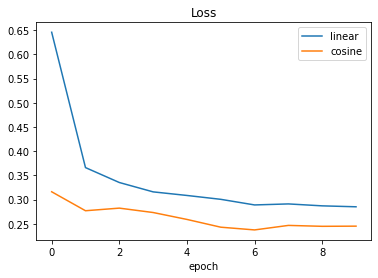

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['linear', 'cosine'])
plt.title('Loss')
plt.xlabel('epoch')

Problem 5: Perform an interpolation experiment with your trained model from Problem 4 (You should output a figure like Fig. 8 in the paper).

In [ ]:
! [ ! -z "$COLAB_GPU" ] && pip install torch scikit-learn==0.20.* skorch

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [ ]:
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X /= 255.0
X.min(), X.max()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
assert(X_train.shape[0] + X_test.shape[0] == mnist.data.shape[0])

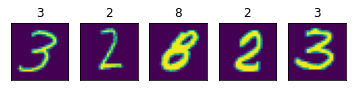

In [ ]:
def plot_sample(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)
plot_sample(X_train, y_train)